<a href="https://colab.research.google.com/github/neelkanthrawat/QBM_sept2022/blob/main/qbm_codes/qmcmc_trial_v0.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [ ]:
!pip install qiskit ipywidgets # while working on google colab!

In [3]:
# while working on google colab, run this cell
!wget https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/main/qbm_codes/qbm_utils.py

--2022-10-01 07:27:46--  https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/main/qbm_codes/qbm_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17062 (17K) [text/plain]
Saving to: ‘qbm_utils.py.2’

qbm_utils.py.2      100%[===================>]  16.66K  --.-KB/s    in 0s      

2022-10-01 07:27:47 (98.2 MB/s) - ‘qbm_utils.py.2’ saved [17062/17062]



In [4]:
from qbm_utils import *

In [5]:
# define the model
## put n_spins even always
n_spins = 4

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)
J =  np.random.randn(n_spins,n_spins)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )
h = np.random.randn(n_spins)#np.random.uniform(low= -1, high = 1, size= (n_spins))

# instantiate the model
model = IsingEnergyFunction(J, h)

alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )


## Some updated funcs

In [6]:
def classical_mcmc(N_hops:int, num_spins:int, num_elems:int, model, return_last_n_states=500, return_both_classical_and_quantum_steps=False ):
    ''' 
    version 0.2
    Args: 
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)
    model

    Returns:
    Last 'return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it! 
    '''
    states=[]
    current_state=f'{np.random.randint(0,num_elems):0{num_spins}b}'# bin_next_state=f'{next_state:0{num_spins}b}'
    print("starting with: ", current_state) 

    ## initialiiise observables
    #observable_dict = dict([ (elem, []) for elem in observables ])
    list_after_transition=[]
    list_after_acceptance_step=[]

    for i in tqdm(range(0, N_hops)):
        states.append(current_state)
        # get sprime
        s_prime=classical_transition(num_spins)
        list_after_transition.append(s_prime)
        # accept/reject s_prime 
        energy_s=model.get_energy(current_state)
        energy_sprime=model.get_energy(s_prime)
        next_state= classical_loop_accepting_state(current_state, s_prime, energy_s, energy_sprime,temp=1)
        current_state= next_state
        list_after_acceptance_step.append(current_state)
        # if store_observables:  ## store the observables 
          
        #   if next_state == s_prime: observable_dict['acceptance'].append('True')
        #   else: observable_dict['acceptance'].append('False')
        #   observable_dict['energy'].append(model.get_energy(next_state))

        ## reinitiate
        qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
    
    # returns dictionary of occurences for last "return_last_n_states" states
    dict_count_return_last_n_states=Counter(states[-return_last_n_states:])
    
    if return_both_classical_and_quantum_steps: 
        to_return = dict_count_return_last_n_states, list_after_transition, list_after_acceptance_step
    else: 
        to_return= dict_count_return_last_n_states 
    
    return to_return

In [7]:
def quantum_enhanced_mcmc(N_hops:int, num_spins:int, num_elems:int, model:IsingEnergyFunction, alpha, num_trotter_steps=10, return_last_n_states=500, return_both_classical_and_quantum_steps=False):
    ''' 
    version 0.2
    Args: 
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)

    Returns:
    Last 'return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it! 
    '''
    states=[]
    current_state=f'{np.random.randint(0,num_elems):0{num_spins}b}'# bin_next_state=f'{next_state:0{num_spins}b}'
    print("starting with: ", current_state) 
    ## initialise quantum circuit to current_state
    qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
    #print("qc_s is:"); print(qc_s.draw())

    ## intialise observables
    #observable_dict = dict([ ( elem, []  ) for elem in observables ])
    list_after_transition=[]
    list_after_acceptance_step=[]

    for i in tqdm(range(0, N_hops)):
        #print("i: ", i)
        states.append(current_state)
        # get sprime
        s_prime=run_qc_quantum_step(qc_initialised_to_s=qc_s, model= model, alpha=alpha, n_spins=num_spins, num_trotter_steps=num_trotter_steps, time=0.8)
        list_after_transition.append(s_prime)
        # accept/reject s_prime 
        energy_s=model.get_energy(current_state)
        energy_sprime=model.get_energy(s_prime)
        next_state= classical_loop_accepting_state(current_state, s_prime, energy_s, energy_sprime,temp=1)
        current_state=next_state
        # if current_state!=next_state:# this seems to be a redundant step. I could have set current_state=classical_loop_accepting_state(current_state, s_prime, energy_s, energy_sprime,temp=1)
        #   current_state= next_state
        list_after_acceptance_step.append(current_state)

        # if store_observables:  ## store the observables 
          
        #   if next_state == s_prime: observable_dict['acceptance'].append('True')
        #   else: observable_dict['acceptance'].append('False')
        #   observable_dict['energy'].append(model.get_energy(next_state))

        ## reinitiate
        qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
      
    dict_count_return_last_n_states=Counter(states[-return_last_n_states:])#dictionary of occurences for last "return_last_n_states" states

    if return_both_classical_and_quantum_steps: 
      to_return= dict_count_return_last_n_states, list_after_transition, list_after_acceptance_step
    else: 
      to_return= dict_count_return_last_n_states

    return to_return

In [8]:
def states(num_spins:int)->list:
    ''' 
    Returns all possible binary strings of length n=num_spins

    Args:
    num_spins: n length of the bitstring
    Returns:
    possible_states= list of all possible binary strings of length num_spins
    '''
    num_possible_states=2**(num_spins)
    possible_states=[f'{k:0{num_spins}b}' for k in range(0,num_possible_states)]
    return possible_states

def magnetization_of_state(bitstring:str)->float:
    '''  
    Args:
    bitstring: for eg: '010'
    Returns:
    magnetization for the given bitstring
    '''
    array=np.array(list(bitstring))
    num_times_one=np.count_nonzero(array=='1')
    num_times_zero=len(array)-num_times_one
    magnetization=num_times_one-num_times_zero
    return magnetization

def dict_magnetization_of_all_states(list_all_possible_states:list)->dict:
    '''
    Returns magnetization for all unique states
    
    Args:
    list_all_possible_states
    Returns:
    dict_magnetization={state(str): magnetization_value}
    '''
    list_mag_vals=[magnetization_of_state(state) for state in list_all_possible_states]
    dict_magnetization=dict(zip(list_all_possible_states, list_mag_vals ))
    #print("dict_magnetization:"); print(dict_magnetization)
    return dict_magnetization

## Run classical MCMC

In [9]:
states_nbit=states(num_spins=4)
dict_mag=dict_magnetization_of_all_states(states_nbit)

starting with:  0011


100%|██████████| 1000/1000 [00:00<00:00, 5790.88it/s]


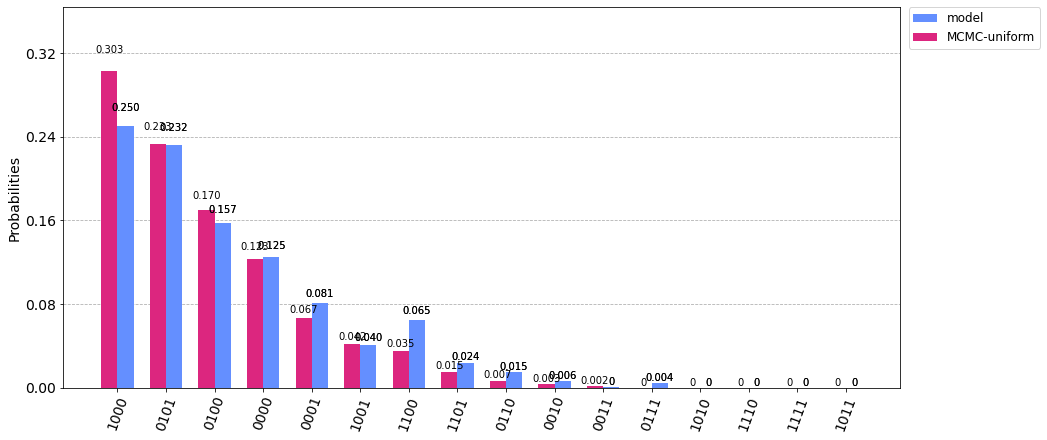

In [10]:
# symmetric uniform transition matrix for uniform transition rule
num_spins=4
num_elems=2**(num_spins)
transit_mat=np.ones((num_elems,num_elems))*(1./(2*num_elems))# in general case transit matrix could be entirely different
np.fill_diagonal(transit_mat, 1./2)

# Run MCMC with uniform random transition strategy
N_hops=1000
dict_states_mcmc, cl_mcmc_after_trsn, cl_mcmc_after_accept =classical_mcmc(N_hops, num_spins, num_elems,model, return_last_n_states=600, return_both_classical_and_quantum_steps=True)

# get actual probability distribution
transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in states_nbit ] )
# plot actual prob distribution as well as one obtained from MCMC
plot_histogram( [transits_bltz, dict_states_mcmc] , figsize=(15, 7), legend= ['model', 'MCMC-uniform'], sort="value_desc")

## Run quantum enhanced MCMC

In [11]:
# symmetric uniform transition matrix for uniform transition rule: tho tbh I dont need it
num_spins=4
num_elems=2**(num_spins)
transit_mat=np.ones((num_elems,num_elems))*(1./(2*num_elems))# in general case transit matrix could be entirely different
np.fill_diagonal(transit_mat, 1./2)

# Run MCMC with uniform random transition strategy
N_hops=1000
dict_states_quantum_mcmc, quant_mcmc_after_trsn, quant_mcmc_after_accept =quantum_enhanced_mcmc(N_hops, 
num_spins, num_elems, model, alpha, num_trotter_steps=10, 
return_last_n_states=600,return_both_classical_and_quantum_steps=True)

# get actual probability distribution
transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in states_nbit ] )
# plot actual prob distribution as well as one obtained from MCMC
#plot_histogram( [transits_bltz, dict_states_quantum_mcmc] , figsize=(15, 7), legend= ['model', 'Quantum-enhanced MCMC' ])#, sort= 'value_desc')

starting with:  0101


100%|██████████| 1000/1000 [03:18<00:00,  5.04it/s]


In [12]:
transits_bltz

{'0000': 1.0,
 '0001': 0.650350690905245,
 '0010': 0.05077102304686849,
 '0011': 0.006357185078724826,
 '0100': 1.2614245170004406,
 '0101': 1.8580941408767742,
 '0110': 0.11770081310362623,
 '0111': 0.03338007007394898,
 '1000': 2.0046040018097506,
 '1001': 0.3245055466402015,
 '1010': 0.0004888405091943723,
 '1011': 1.5235687421439815e-05,
 '1100': 0.5209034602745566,
 '1101': 0.19098955377290475,
 '1110': 0.00023345227900491112,
 '1111': 1.6479795735933928e-05}

In [13]:
rqd_sum=np.sum(np.array(list(transits_bltz.values())))
print(rqd_sum)
prob_vals=list(np.array(list(transits_bltz.values()))*(1./rqd_sum))
boltz_prob_distn=dict(zip(list(transits_bltz.keys()), prob_vals ))
print(boltz_prob_distn)

8.019835010854397
{'0000': 0.12469084446831588, '0001': 0.08109277684952768, '0010': 0.006330681738234359, '0011': 0.0007926827759075757, '0100': 0.15728808825782242, '0101': 0.23168732752755486, '0110': 0.014676213780498574, '0111': 0.004162189125932257, '1000': 0.24995576581022322, '1001': 0.04046287064521919, '1010': 6.095393590176781e-05, '1011': 1.8997507306346286e-06, '1100': 0.0649518923481023, '1101': 0.02381464874457032, '1110': 2.9109361812175257e-05, '1111': 2.0548796469789525e-06}


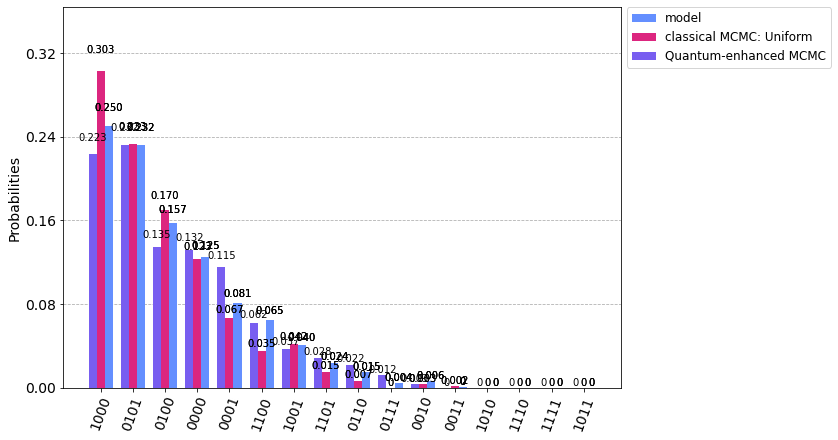

In [14]:
plot_histogram( [transits_bltz,dict_states_mcmc, dict_states_quantum_mcmc] , figsize=(10, 7), legend= ['model', 'classical MCMC: Uniform','Quantum-enhanced MCMC' ], sort='value_desc')

### comparing number of accpeted/rejected samples

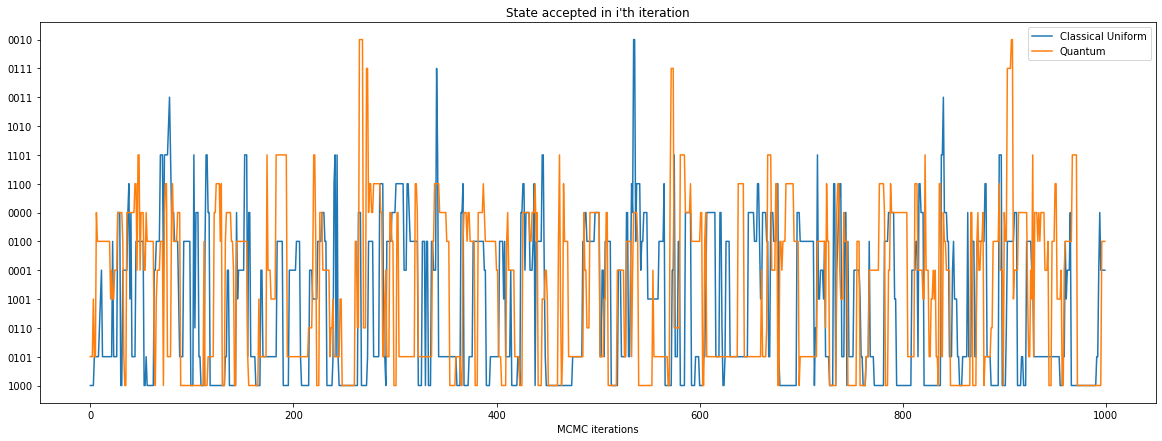

In [15]:
# plt.figure(figsize=(20,7))
# plt.plot(cl_mcmc_after_trsn, label="Classical Uniform")
# plt.plot(quant_mcmc_after_trsn, label="Quantum")
# plt.xlabel("MCMC iterations")
# plt.title("after transition")
plt.figure(figsize=(20,7))
#quant_mcmc_after_trsn, quant_mcmc_after_accept
plt.plot(cl_mcmc_after_accept, label="Classical Uniform")
plt.plot(quant_mcmc_after_accept,label="Quantum")
plt.xlabel("MCMC iterations")
plt.title("State accepted in i'th iteration")
plt.legend()

Next task:
For different problem instances, do the following:

1. Running average: magnetization. **(DONE)**

2.  For first few relevant states (high probability), check how many times were those states accepted/rejected out of total number of iterations considered for the prob distn. **(CODE IS COMPLETE, NOW WE NEED TO RUN SOME EXPERIEMENTS)**

3. Overlap with the desired distribution.


## Running average; magnetization

In [16]:
def get_distn(list_of_samples:list)-> dict:
  '''   
  Returns the dictionary of distn for input list_of_samples
  '''
  len_list=len(list_of_samples)
  temp_dict=Counter(list_of_samples)
  temp_prob_list=np.array(list(temp_dict.values()))*(1./len_list)
  dict_to_return=dict(zip( list(temp_dict.keys()), temp_prob_list))
  return dict_to_return

In [17]:
def avg(dict_probabilities:dict, dict_observable_val_at_states:dict):
  ''' 
  Returns average of any observable of interest

  Args:
  dict_probabilities= {state: probability}
  dict_observable_val_at_states={state (same as that of dict_probabilities): observable's value at that state}

  Returns:
  avg
  '''
  len_dict=len(dict_probabilities)
  temp_array=np.zeros((len_dict,))
  temp_list=[dict_probabilities[j]*dict_observable_val_at_states[j] for j in (list(dict_probabilities.keys())) ]
  avg=np.mean(temp_list)
  return avg

In [18]:
### function to get running average of magnetization
def running_avg_magnetization(list_states_mcmc:list):
  ''' 
  Returns the running average magnetization 

  Args:
  list_states_mcmc= List of states aceepted after each MCMC step
  '''
  len_iters_mcmc=len(list_states_mcmc)
  running_avg_mag={}
  for i in tqdm(range(1,len_iters_mcmc)):
    temp_list=list_states_mcmc[:i]#[:i]
    temp_prob=get_distn(temp_list)
    dict_mag_states_in_temp_prob=dict_magnetization_of_all_states(temp_list)
    running_avg_mag[i]=avg(temp_prob, dict_mag_states_in_temp_prob)
  return running_avg_mag

In [19]:
check_cl=running_avg_magnetization(list_states_mcmc=cl_mcmc_after_accept)
check_quant=running_avg_magnetization(list_states_mcmc=quant_mcmc_after_accept)

100%|██████████| 999/999 [00:01<00:00, 595.36it/s]


In [20]:
def plot_dict_of_running_avg_observable(dict_running_avg:dict, observable_legend_label:str):
  plt.plot(list(dict_running_avg.keys()), list(dict_running_avg.values()),"-" ,label=observable_legend_label)
  plt.xlabel("MCMC iterations")

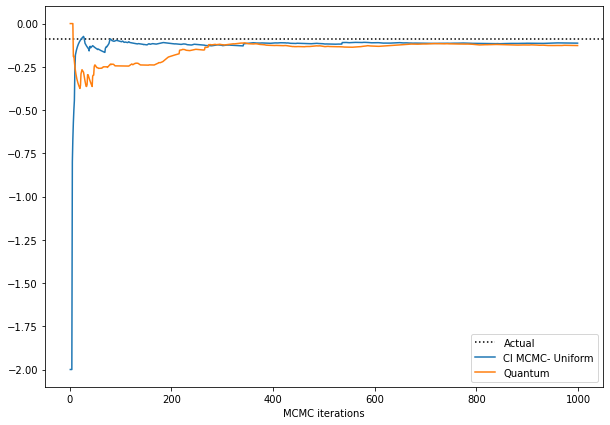

In [21]:
plt.figure(figsize=(10,7))
magnetization_of_all_states=dict_magnetization_of_all_states(states_nbit)
actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=magnetization_of_all_states)
plt.axhline(y=actual_avg_mag,linestyle=":", color="k" ,label="Actual")
plot_dict_of_running_avg_observable(check_cl, "Cl MCMC- Uniform")
plot_dict_of_running_avg_observable(check_quant, "Quantum")
plt.legend()

## Sampling related

In [23]:
# cl_mcmc_after_trsn, cl_mcmc_after_accept
# quant_mcmc_after_trsn, quant_mcmc_after_accept 

def fn_numtimes_bitstring_not_accepted(list_after_trsn, list_after_accept, bitstring):

  where_sprime_is_bitstr=list(np.where( np.array(list_after_trsn) == bitstring)[0])
  where_bitstr_not_accepted=[k for k in where_sprime_is_bitstr if list_after_accept[k]!=bitstring]
  numtimes_sprime_is_bitstring= len(where_sprime_is_bitstr)
  numtimes_bitstring_not_accepted=len(where_bitstr_not_accepted)
  return numtimes_bitstring_not_accepted, numtimes_sprime_is_bitstring

def fn_states_not_accepted(list_states:list, list_after_trsn:list, list_after_accept:list):
  list_numtimes_state_not_accepted=[fn_numtimes_bitstring_not_accepted(list_after_trsn, list_after_accept,k)[0] for k in list_states]
  list_numtimes_sprime_is_state=[fn_numtimes_bitstring_not_accepted(list_after_trsn, list_after_accept,k)[1] for k in list_states]
  dict_numtimes_states_not_accepted=dict(zip(list_states, list_numtimes_state_not_accepted))
  dict_numtimes_sprime_is_state=dict(zip(list_states, list_numtimes_sprime_is_state))
  return dict_numtimes_states_not_accepted, dict_numtimes_sprime_is_state

aa,bb=fn_states_not_accepted(list_states=states_nbit, list_after_trsn=cl_mcmc_after_trsn, list_after_accept=cl_mcmc_after_accept)
print(aa); print(bb)
# fn_numtimes_bitstring_not_accepted(list_after_trsn=cl_mcmc_after_trsn, list_after_accept=cl_mcmc_after_accept,bitstring='0000')

{'0000': 17, '0001': 38, '0010': 56, '0011': 60, '0100': 17, '0101': 0, '0110': 47, '0111': 57, '1000': 0, '1001': 41, '1010': 66, '1011': 70, '1100': 30, '1101': 57, '1110': 51, '1111': 63}
{'0000': 57, '0001': 72, '0010': 57, '0011': 62, '0100': 77, '0101': 69, '0110': 52, '0111': 58, '1000': 65, '1001': 58, '1010': 67, '1011': 70, '1100': 48, '1101': 74, '1110': 51, '1111': 63}
